# MNIST Digit Classification
This notebook utilizes deep learning to classify the handwritten digits of the MNIST dataset. 


## Setup

In [1]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torch.utils.data import DataLoader, Dataset

In [2]:
SEED = 0
datapath = r"./data"
savepath = r"./output"
device = "cuda:0"

In [3]:
print("PyTorch Version: ",torch.__version__)

print("CUDA is available" if torch.cuda.is_available() else "CUDA is not available")
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

PyTorch Version:  2.2.1+cu121
CUDA is available
NVIDIA GeForce RTX 4070 Laptop GPU


In [4]:
os.makedirs(savepath, exist_ok=True)

In [5]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
val_freq = 1

in_dim = 784 #28*28 
hidden_dim = 100
out_dim = 10

mean = 0.1307
std = 0.3081

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(SEED)

## Data

In [7]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((mean,), (std,))
                ])

In [8]:
class MNISTDataset(Dataset):
    """
    MNIST dataset

    Args:
    - root: path to the csv file
    - transform: image transformation


    """
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = pd.read_csv(os.path.join(root))

    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data.iloc[idx, 1:].values.reshape(28, 28).astype(np.float32)
        label = self.data.iloc[idx, 0]
        
        if self.transform:
            img = self.transform(img)
        return img, label
    

In [9]:
dataset_train = MNISTDataset(os.path.join(datapath, "train.csv"), transform=transform)
dataset_test = MNISTDataset(os.path.join(datapath, "test.csv"), transform=transform)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False)


In [10]:
# Alternative: PyTorch built-in MNIST dataset class 

# dataset_train =   torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)

# dataset_test =  torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)
# dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False)

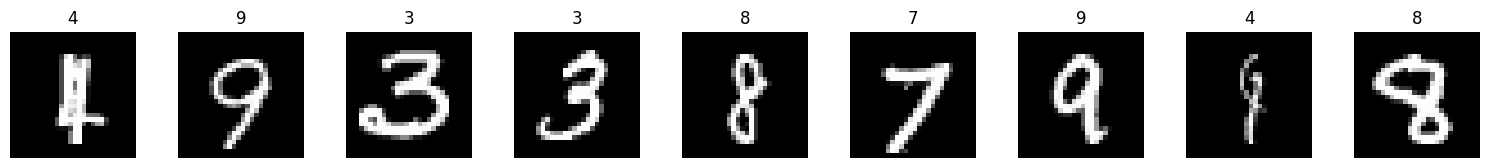

In [11]:
# Display train dataset samples

fig = plt.figure(figsize=(15, 5))
for i in range(n:=9):
    idx = random.randint(0, len(dataset_train))
    plt.subplot(1,n,i+1)
    img = (dataset_train[idx][0].squeeze() * std) + mean
    plt.imshow(img, cmap='gray')
    plt.title(f"{dataset_train[idx][1]}")

    plt.tight_layout()
    plt.axis('off')

## Model

In [12]:
class FeedForwardNN(nn.Module):
  """
  A simple feedforward neural network with one hidden layer, ReLU and log-softmax.

  Args:
  - in_dim: input dimension
  - hidden_dim: hidden layer dimension
  - out_dim: output dimension
  
  """
  def __init__(self, in_dim, hidden_dim, out_dim):
    super().__init__()
    self.layer1 = torch.nn.Linear(in_dim, hidden_dim)
    self.layer2 = torch.nn.Linear(hidden_dim, out_dim)

    self.apply(self._init_weights)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    return F.log_softmax(self.layer2(x), dim=1)
  
  def _init_weights(self, m):
      """Normal weight initialization."""
      if isinstance(m, nn.Linear):
          nn.init.normal_(m.weight, mean=0, std=0.01)
          if isinstance(m, nn.Linear) and m.bias is not None:
              nn.init.constant_(m.bias, 0)


In [13]:
model = FeedForwardNN(in_dim, hidden_dim, out_dim)
model.to(device)

FeedForwardNN(
  (layer1): Linear(in_features=784, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=10, bias=True)
)

## Training Setup

For training, SGD with momentum is used together with the negative log likelihood loss function. 

In [14]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.NLLLoss()

In [15]:
# Metrics tracking

train_stats = {
    "step": [],
    "epoch_loss": [],
    "iter_loss": [],
}   

test_stats = {
    "step": [],
    "epoch_loss": [],
    "iter_loss": [],
    "tp": [],
}

In [22]:
def train(epoch:int, log=False):
    """
    Train one epoch.
    """
    model.train()
    train_loss = 0.0
    for idx, data in enumerate(dataloader_train):
        img, label = data
        img.to(device)
        label.to(device)

        img = img.view(-1, 28*28)
        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()

        output = model(img)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if log:
            train_stats["step"].append(epoch * len(dataloader_train) + idx)
            train_stats["iter_loss"].append(loss.item())


    train_loss /= len(dataloader_train)
    if log:
        train_stats["epoch_loss"].append(train_loss)

        if epoch == 0 or train_loss < min(train_stats["epoch_loss"]):
            torch.save(model.state_dict(), os.path.join(savepath, "best.pt"))
    torch.save(model.state_dict(), os.path.join(savepath, "last.pt"))
    

    print(f"[TRAIN] Epoch: {epoch}/{n_epochs}, Loss: {train_loss:.4f}")

def test(epoch:int, log=False):
    """
    Test at epoch.
    """
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for idx, data in enumerate(dataloader_test):
            img, label = data
            img.to(device)
            label.to(device)

            img = img.view(-1, 28*28)
            img, label = img.to(device), label.to(device)

            output = model(img)
            loss = criterion(output, label)
            val_loss += loss.item()

            _, predicted = torch.max(output, 1)
            tp = (predicted == label).sum().item()

            if log:
                test_stats["step"].append(epoch * len(dataloader_test) + idx)
                test_stats["iter_loss"].append(loss.item())
                test_stats["tp"].append(tp)
        
        val_loss /= len(dataloader_test)
        if log:
            test_stats["epoch_loss"].append(val_loss)
        print(f"[VAL] Epoch: {epoch}/{n_epochs}, Loss: {val_loss:.4f}")

In [17]:
# Training loop on gpu
device = "cuda:0"
model.to(device)
total_time = 0
for epoch in range(n_epochs):
    s_time = time.time()
    train(epoch, log=True)
    total_time += time.time() - s_time
    if epoch % val_freq == 0:
        test(epoch, log=True)
print(f"Finished Training in {total_time:.2f} seconds")

[TRAIN] Epoch: 0/10, Loss: 75.5406
[VAL] Epoch: 0/10, Loss: 2.3011
[TRAIN] Epoch: 1/10, Loss: 2.3012
[VAL] Epoch: 1/10, Loss: 2.3011
[TRAIN] Epoch: 2/10, Loss: 2.3013
[VAL] Epoch: 2/10, Loss: 2.3011
[TRAIN] Epoch: 3/10, Loss: 2.3013
[VAL] Epoch: 3/10, Loss: 2.3010
[TRAIN] Epoch: 4/10, Loss: 2.3013
[VAL] Epoch: 4/10, Loss: 2.3010
[TRAIN] Epoch: 5/10, Loss: 2.3013
[VAL] Epoch: 5/10, Loss: 2.3011
[TRAIN] Epoch: 6/10, Loss: 2.3013
[VAL] Epoch: 6/10, Loss: 2.3010
[TRAIN] Epoch: 7/10, Loss: 2.3013
[VAL] Epoch: 7/10, Loss: 2.3010
[TRAIN] Epoch: 8/10, Loss: 2.3013
[VAL] Epoch: 8/10, Loss: 2.3010
[TRAIN] Epoch: 9/10, Loss: 2.3013
[VAL] Epoch: 9/10, Loss: 2.3010
Finished Training.


In [24]:
# Training loop on cpu
device = "cpu"
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.NLLLoss()

for epoch in range(n_epochs):
    train(epoch)
    if epoch % val_freq == 0:
        test(epoch)
print(f'Finished Training in {total_time:.2f} seconds')

[TRAIN] Epoch: 0/10, Loss: 2.3013
[VAL] Epoch: 0/10, Loss: 2.3010
[TRAIN] Epoch: 1/10, Loss: 2.3013
[VAL] Epoch: 1/10, Loss: 2.3010
[TRAIN] Epoch: 2/10, Loss: 2.3013
[VAL] Epoch: 2/10, Loss: 2.3010
[TRAIN] Epoch: 3/10, Loss: 2.3013
[VAL] Epoch: 3/10, Loss: 2.3010
[TRAIN] Epoch: 4/10, Loss: 2.3013
[VAL] Epoch: 4/10, Loss: 2.3010
[TRAIN] Epoch: 5/10, Loss: 2.3013
[VAL] Epoch: 5/10, Loss: 2.3010


KeyboardInterrupt: 

## Evaluation

In [25]:
print(f"Lowest loss found [{min(train_stats['epoch_loss']):.3f}] at epoch {np.argmin(train_stats['epoch_loss'])}")
print(f'Accuracy: {np.sum(test_stats["tp"])/len(dataset_test)}')

Lowest loss found [2.301154835391909] at epoch 1
Accuracy: 1.135


In [ ]:
fig = plt.figure(figsize=(10, 5))
# Epoch loss
plt.subplot(1,2,1)
plt.plot(train_stats["epoch_loss"], label="train")
plt.plot(test_stats["epoch_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Iteration loss
plt.subplot(1,2,2)
plt.plot(train_stats["iter_loss"], label="train_iter", alpha=0.5)
plt.plot(test_stats["iter_loss"], label="test_iter", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()